# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library2D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

## Prepare the data

Next, we prepare the dataset.

In [232]:
data = np.load('diffusion_advection_27long.npy')[2:22,20:120,150:250].T

In [233]:
data.shape

(100, 100, 20)

In [234]:
down_data= np.take(np.take(data,np.arange(0,data.shape[0],5),axis=0),np.arange(0,data.shape[1],5),axis=1)

In [235]:
down_data.shape

(20, 20, 20)

In [236]:
steps = down_data.shape[2]
width = down_data.shape[0]
width_2 = down_data.shape[1]

In [237]:
x_arr = np.arange(0,width)
y_arr = np.arange(0,width_2)
t_arr = np.arange(0,steps)
x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')
X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))

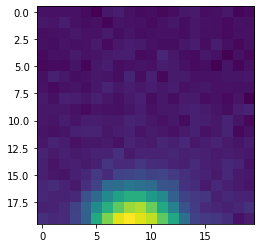

In [238]:
plt.imshow(down_data[:,:,1])

Next we plot the dataset for three different time-points

We flatten it to give it the right dimensions for feeding it to the network:

In [239]:
X = np.transpose((t_grid.flatten()/5., x_grid.flatten()/100, y_grid.flatten()/100))
#X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))

y = np.float32(down_data.reshape((down_data.size, 1)))
y = y/np.max(y)

In [240]:
y.shape

(8000, 1)

In [241]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)



## Configuration of DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [242]:
network = NN(3, [30, 30, 30,30], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_y, u_{xx}, u_{yy}, u_{xy}, u, u u_x, u u_y, u u_{xx}, u u_{yy}, u u_{xy}$]

In [243]:
library = Library2D(poly_order=0) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [244]:
estimator = Threshold(0.025) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 


Configuration of the sparsity estimator 

In [245]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [246]:
model = DeepMoD(network, library, estimator, constraint)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [247]:
train(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/test7/', split=0.8, max_iterations=100000, delta=1e-7, patience=80) 

 39125  MSE: 4.62e-04  Reg: 3.23e-05  L1: 1.38e+00 

KeyboardInterrupt: 

Sparsity masks provide the active and non-active terms in the PDE:

In [102]:
sol = model(torch.tensor(X, dtype=torch.float32))[0].reshape((width,width_2,steps))

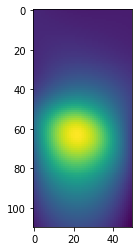

In [103]:
plt.imshow(sol[:,:,40].detach().numpy())

In [14]:
model.sparsity_masks

[tensor([False,  True,  True,  True,  True, False, False, False, False, False,
         False, False])]

estimatior_coeffs gives the magnitude of the active terms:

In [61]:
print(model.estimator_coeffs())

[array([[ 0.        ],
       [ 0.        ],
       [-0.32624507],
       [ 0.22825544],
       [ 0.        ],
       [-0.1876074 ],
       [ 0.        ],
       [ 0.22351576],
       [-0.35876325],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)]
